Max Schrader

3/8/2021

In [1]:
import random
from functools import wraps
from time import time
import plotly.graph_objects as go

In [2]:
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        return te - ts, result
    return wrap

In [3]:
class WindyGridworld:

    def __init__(self):
        self.REWARD = -1
        self.WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]
        self.X_RANGE = (0, 9)
        self.Y_RANGE = (0, 6)
        self.STARTING_POSITION = (0, 3)
        self.GOAL_POSITION = (7, 3)
        self.ACTION_SPACE = ((-1, 0), (0, 1), (1, 0), (0, -1))
        self.STATE_SPACE = [(i, j) for j in range(self.Y_RANGE[-1] + 1) for i in range(self.X_RANGE[-1] + 1)]
        self.Q = self._compose_Q()

    def _get_flattened_index(self, s):
        return s[0] + s[1] * (self.X_RANGE[-1] + 1)

    def _compose_Q(self):
        Q = [[self.REWARD for _ in self.ACTION_SPACE] for _ in self.STATE_SPACE]
        Q[self._get_flattened_index(self.GOAL_POSITION)][:] = [0] * len(self.ACTION_SPACE)
        return Q

    def _check_goal_achieved(self, s):
        return (s[0] == self.GOAL_POSITION[0]) and (s[1] == self.GOAL_POSITION[1])

    def _safe_add(self, s, a, wind=False):
        x = min(max(self.X_RANGE[0], s[0] + a[0]), self.X_RANGE[1])
        y = min(max(self.Y_RANGE[0], s[1] + a[1] + self.WIND[s[0]]), self.Y_RANGE[1]) if wind else \
            min(max(self.Y_RANGE[0], s[1] + a[1]), self.Y_RANGE[1])
        return [x, y]

    def _get_possible_actions(self, s):
        possible_actions = []
        for i, action in enumerate(self.ACTION_SPACE):
            unconstrained = self._safe_add(s, action, wind=True)
            unconstrained[0] = min(max(self.X_RANGE[0], unconstrained[0]), self.X_RANGE[1])
            unconstrained[1] = min(max(self.Y_RANGE[0], unconstrained[1]), self.Y_RANGE[1])
            if unconstrained != s:
                possible_actions.append((action, i))
        return possible_actions

    def e_greedy(self, s, epsilon):
        potential_actions = self._get_possible_actions(s)
        if random.random() <= epsilon:
            return random.choice(potential_actions)
        # s_pi = [self._safe_add(s, action, wind=True) for action, index in potential_actions]
        q_pi = [self.Q[self._get_flattened_index(s)][i] for _, i in potential_actions]
        max_q_pi = max(q_pi)
        return random.choice([potential_actions[i] for i, q in enumerate(q_pi) if q >= max_q_pi])

    def Q_s_a(self, s, a, s_p, a_p, r, alpha, gamma):
        q_s_a = self.Q[self._get_flattened_index(s)][a[1]]
        self.Q[self._get_flattened_index(s)][a[1]] = \
            q_s_a + alpha * (r + gamma * self.Q[self._get_flattened_index(s_p)][a_p[1]] - q_s_a)

    def SARSA_step(self, alpha, epsilon, gamma, i):
        S = list(self.STARTING_POSITION)
        A = self.e_greedy(S, epsilon)
        while not self._check_goal_achieved(S):
            S_p = self._safe_add(S, A[0], wind=True)
            A_p = self.e_greedy(S_p, epsilon)
            R = self.REWARD
            self.Q_s_a(S, A, S_p, A_p, R, alpha, gamma)
            S = S_p.copy()
            A = A_p
            i += 1
        return i

    def SARSA_lambda_step(self, i, epsilon, gamma, alpha, lambda_coeff):
        E = [[0 for _ in self.ACTION_SPACE] for _ in self.STATE_SPACE]
        S = list(self.STARTING_POSITION)
        A = self.e_greedy(S, epsilon)
        while not self._check_goal_achieved(S):
            S_p = self._safe_add(S, A[0], wind=True)
            A_p = self.e_greedy(S_p, epsilon)
            R = self.REWARD
            flat_S = self._get_flattened_index(S) 
            delta = R + gamma * self.Q[self._get_flattened_index(S_p)][A_p[1]] - self.Q[flat_S][A[1]]
            E[flat_S][A[1]]= E[flat_S][A[1]]+ 1
            for s in self.STATE_SPACE:
                for a in self._get_possible_actions(s):
                    flat_s = self._get_flattened_index(s)
                    self.Q[flat_s][a[1]] = self.Q[flat_s][a[1]] + alpha * delta * E[flat_s][a[1]]
                    E[flat_s][a[1]] = gamma * lambda_coeff * E[flat_s][a[1]]
            S = S_p
            A = A_p
            i += 1
        return i

    @timing
    def SARSA(self, episodes, alpha, epsilon, gamma, epsilon_decay):
        iterations = [0]
        self._compose_Q()
        for j in range(episodes):
            epsilon = max((epsilon - epsilon_decay), 0.01)
            i = self.SARSA_step(alpha, epsilon, gamma, iterations[-1])
            iterations.append(i)
        return iterations

    @timing
    def SARSA_lambda(self, episodes, epsilon, gamma, alpha, lambda_coeff):
        iterations = [0]
        self._compose_Q()
        for _ in range(episodes):
            i = self.SARSA_lambda_step(iterations[-1], epsilon, gamma, alpha, lambda_coeff)
            iterations.append(i)
        return iterations

    def print_results(self):
        s_list = [list(self.STARTING_POSITION)]
        while not self._check_goal_achieved(s_list[-1]):
            potential_actions = self._get_possible_actions(s_list[-1])
            q_pi = [self.Q[self._get_flattened_index(s_list[-1])][i] for _, i in potential_actions]
            max_q_pi = max(q_pi)
            a = random.choice([potential_actions[i] for i, q in enumerate(q_pi) if q >= max_q_pi])
            s_list.append(self._safe_add(s_list[-1], a[0], wind=True))

        gridworld = [["-" for i in range(self.X_RANGE[-1] + 1)] for _ in range(self.Y_RANGE[-1] + 1)]
        for state in s_list:
            gridworld[state[1]][state[0]] = 'X'
        for state in [self.STARTING_POSITION, self.GOAL_POSITION]:
            gridworld[state[1]][state[0]] = 'O'

        for i, _ in enumerate(gridworld):
            print("  ".join(gridworld[len(gridworld) - 1 - i]) + "\n")

# Part 1

I found the best results to be when:

$$\alpha = 0.5$$
$$\gamma = 0.9$$
$$\epsilon = 0.1$$

SARSA took 0.161s


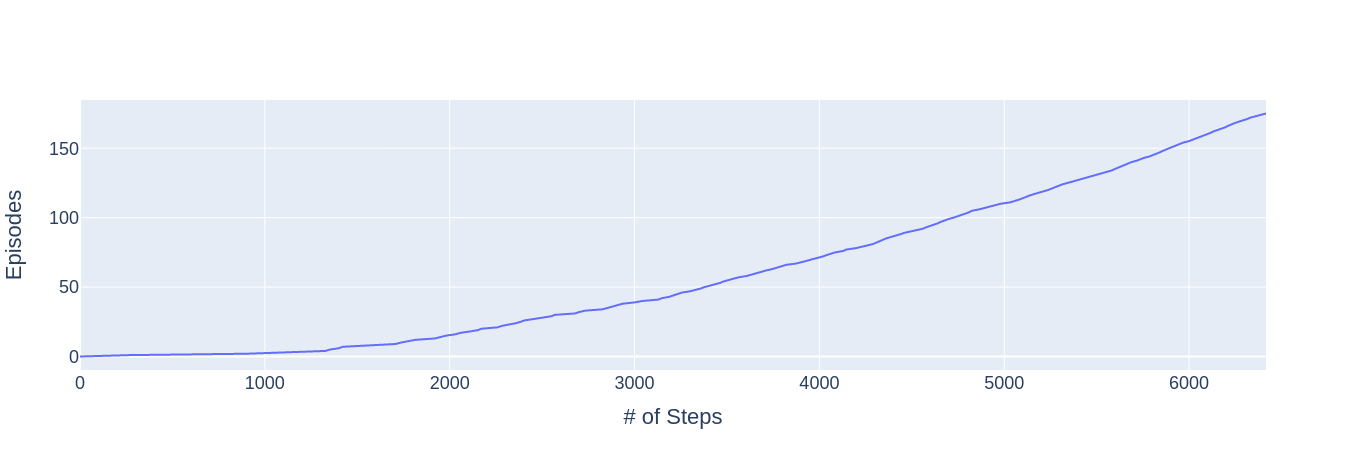

In [20]:
wg = WindyGridworld()

execution_time, iteration_num = wg.SARSA(episodes=175, alpha=0.5, gamma=0.9, epsilon=.1, epsilon_decay=0)

print(f"SARSA took {round(execution_time, 3)}s")

fig = go.Figure()
fig.add_trace(go.Scatter(x=iteration_num, y=list(range(500))))
fig.update_layout(xaxis_title="# of Steps", yaxis_title='Episodes', font=dict(size=18))

## Printing the SARSA Gridworld Solution

In [17]:
wg.print_results()

-  -  -  -  -  -  X  X  X  X

-  -  -  -  -  X  -  -  -  X

-  -  -  -  X  -  -  -  -  X

O  X  X  X  -  -  -  O  -  X

-  -  -  -  -  -  -  -  X  X

-  -  -  -  -  -  -  -  -  -

-  -  -  -  -  -  -  -  -  -



# Part 2

I found the best results to be when:

$$\lambda = 0.5$$
$$\alpha = 0.5$$
$$\gamma = 0.9$$
$$\epsilon = 0.1$$

SARSA(lambda) took 4.297s


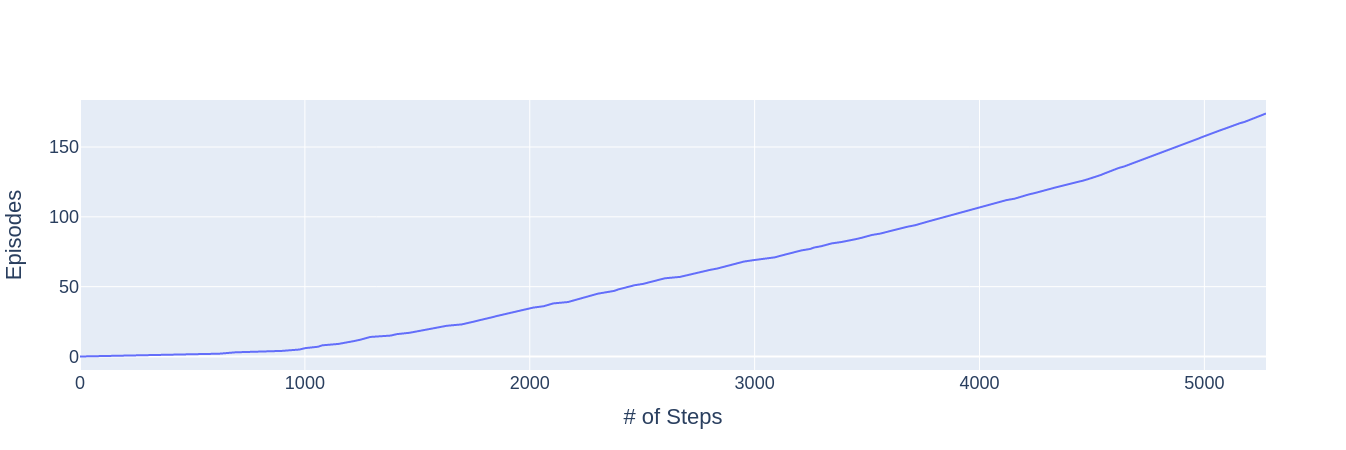

In [21]:
wg = WindyGridworld()

execution_time, iteration_num = wg.SARSA_lambda(episodes=175, lambda_coeff=0.5, alpha=0.5, gamma=0.9, epsilon=.1,)

print(f"SARSA(lambda) took {round(execution_time, 3)}s")

fig = go.Figure()
fig.add_trace(go.Scatter(x=iteration_num, y=list(range(175))))
fig.update_layout(xaxis_title="# of Steps", yaxis_title='Episodes', font=dict(size=18))

In [7]:
wg.print_results()

-  -  -  -  -  -  X  X  X  X

-  -  -  -  -  X  -  -  -  X

-  -  -  -  X  -  -  -  -  X

O  X  X  X  -  -  -  O  -  X

-  -  -  -  -  -  -  -  X  X

-  -  -  -  -  -  -  -  -  -

-  -  -  -  -  -  -  -  -  -

